In [1]:
from time import time
import warnings
import pandas as pd
import numpy as np
from dython.nominal import associations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score
import lightgbm as lgb

warnings.simplefilter("ignore", category=UserWarning)


plt.rcParams['font.size'] = 14 

# 1.0) Datensätze Laden

In [2]:
alt_ges = pd.read_csv('./data/alter_geschlecht.csv', sep=',')
rest = pd.read_csv('./data/rest.csv', sep=';')
interesse = pd.read_csv("./data/interesse.csv", sep=',')

# 2.0) Vorläufige Datenanalyse

In [3]:
print("Alter-Geschlecht:", alt_ges.shape)
print("Rest:", rest.shape)
print("Interesse:", interesse.shape)

Alter-Geschlecht: (508146, 3)
Rest: (508146, 9)
Interesse: (381109, 2)


## 2.1) Duplizierte IDs

In [4]:
print("Alter-Geschlecht:", alt_ges['id'].duplicated().sum())
print("Rest:", rest['id'].duplicated().sum())
print("Interesse:", interesse['id'].duplicated().sum())

Alter-Geschlecht: 0
Rest: 0
Interesse: 0


## 2.2) Fehlwerte

In keinem Datensatz fehlen Werte. Bei fehlenden Werten sollten Imputationsmethoden wie die [multivariate Imputation (z.B. MICE)](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html) in Betracht gezogen werden.

In [5]:
print("Alter-Geschlecht:\n", alt_ges.isnull().mean(), "\n\n")
print("Rest:\n", rest.isnull().mean(), '\n\n')
print("Interesse:\n", interesse.isnull().mean())

Alter-Geschlecht:
 id            0.0
Geschlecht    0.0
Alter         0.0
dtype: float64 


Rest:
 Fahrerlaubnis      0.0
Regional_Code      0.0
Vorversicherung    0.0
Alter_Fzg          0.0
Vorschaden         0.0
Jahresbeitrag      0.0
Vertriebskanal     0.0
Kundentreue        0.0
id                 0.0
dtype: float64 


Interesse:
 id           0.0
Interesse    0.0
dtype: float64


# 3.0) Zusammenführung von Datensätzen

Da die Anzahl der eindeutigen IDs in den verschiedenen Datensätzen unterschiedlich ist, wird die Schnittmenge der IDs in den verschiedenen Datensätzen verwendet.

In [6]:
df_ = pd.merge(interesse, alt_ges, on='id', how='inner').merge(rest, on='id', how='inner').sort_values(by='id').set_index('id')  # id als Index setzen

Der zusammengeführte Datensatz enthält 381.109 eindeutige IDs und 11 Spalten.

In [7]:
df_.shape

(381109, 11)

# 4.0) Explorative Datenanalyse (EDA)

## 4.1) Spalten-Datentyp

In [8]:
df_.dtypes

Interesse          float64
Geschlecht          object
Alter                int64
Fahrerlaubnis        int64
Regional_Code      float64
Vorversicherung      int64
Alter_Fzg           object
Vorschaden          object
Jahresbeitrag      float64
Vertriebskanal     float64
Kundentreue          int64
dtype: object

## 4.2) Identifizierung von Ausreißern

Alle Werte erscheinen auf den ersten Blick plausibel. Nur der Jahresbeitrag ist statistisch stark rechtsschief, wie wir auch unten genauer anschauen.

### 4.2.1) Numerische Merkmalen

In [9]:
df_.describe()

,Interesse,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Jahresbeitrag,Vertriebskanal,Kundentreue
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,0.122563,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397
std,0.327936,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304
min,0.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000
25%,0.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000
50%,0.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000
75%,0.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000
max,1.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000


### 4.2.2) Kategorische Merkmalen

In [10]:
for col in df_.select_dtypes(include='object').columns:
    print(col, df_[col].unique())

Geschlecht ['Male' 'Female']
Alter_Fzg ['> 2 Years' '1-2 Year' '< 1 Year']
Vorschaden ['Yes' 'No']


## 4.3) Feature Engineering - Spalten in geeignete Datentypen umwandeln

Das folgende ML-Modell erfordert die Konvertierung der Pandas-Objektdatentypen und aller numerisch kodierten kategorialen Merkmale in den Pandas-Kategoriedatentyp. Die numerischen Variablen werden ebenfalls in geeignetere Datentypen konvertiert, um den Speicherbedarf zu reduzieren.

Im Folgenden verwende ich LightGBM, ein Modell, das außer dem richtigen Datentyp nicht viel Feature-Engineering erfordert. Im Gegensatz zu anderen Modellen, wie z.B. Support Vector Machines, ist es nicht notwendig, die kategorialen Merkmale als One-Hot zu transformieren.

In [11]:
df_.dtypes

Interesse          float64
Geschlecht          object
Alter                int64
Fahrerlaubnis        int64
Regional_Code      float64
Vorversicherung      int64
Alter_Fzg           object
Vorschaden          object
Jahresbeitrag      float64
Vertriebskanal     float64
Kundentreue          int64
dtype: object

In [12]:
df = df_.copy()

# Fordert weniger Arbeitsspeicher
df['Jahresbeitrag'] = df['Jahresbeitrag'].astype('int32')
df['Kundentreue'] = df['Kundentreue'].astype('int32')
df['Alter'] = df['Alter'].astype('int8')  # reicht bis 127

categoricals = ['Interesse', 'Fahrerlaubnis', 'Vorversicherung', 'Regional_Code', 'Geschlecht', 'Alter_Fzg', 'Vorschaden', 'Vertriebskanal']
for cat in categoricals:
    if df[cat].dtype == float:  # convert to int first
        df[cat] = df[cat].astype(int)
    df[cat] = df[cat].astype('category')

df.dtypes

Interesse          category
Geschlecht         category
Alter                  int8
Fahrerlaubnis      category
Regional_Code      category
Vorversicherung    category
Alter_Fzg          category
Vorschaden         category
Jahresbeitrag         int32
Vertriebskanal     category
Kundentreue           int32
dtype: object

## 4.4) Zeilenduplikate

Obwohl es keine doppelten IDs gibt, gibt es 269 Zeilen mit identischen Informationen in allen Spalten. Ohne weitere Informationen weiß ich nicht, ob es sich um fehlerhafte Einträge handelt oder ob dies zu erwarten ist (z.B. weil es nur wenige Spalten gibt). Deshalb lösche ich diese Duplikate. 

In [13]:
duplicates = df.duplicated().sum()
print(f"Zeilenduplikate: {duplicates}")

Zeilenduplikate: 269


In [14]:
df = df.drop_duplicates(keep='first')

Der endgültige Analysedatensatz umfasst 380.840 Beobachtungen.

In [15]:
df.shape

(380840, 11)

## 4.5) Erste Zeilen des analytischen Datensatzes

In [16]:
df.head()

,Interesse,Geschlecht,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue
id,,,,,,,,,,,
1,1,Male,44,1,28,0,> 2 Years,Yes,40454,26,217
2,0,Male,76,1,3,0,1-2 Year,No,33536,26,183
3,1,Male,47,1,28,0,> 2 Years,Yes,38294,26,27
4,0,Male,21,1,11,1,< 1 Year,No,28619,152,203
5,0,Female,29,1,41,1,< 1 Year,No,27496,152,39


## 4.6) Univariate Datenanalyse

### 4.6.1) Kategorische Merkmalen

Im Folgenden beschränke ich mich auf kategoriale Merkmale mit niedriger Kardinalität (<=3 Kategorien). 

Wie wir weiter unten sehen, ist ***unsere Ergebnisvariable „Interesse“ klassenungleichgewichtig (Imbalanced), was bedeutet, dass traditionelle Metriken wie die Genauigkeit ungeeignet sind.*** Praktischerweise ist dieses Merkmal auch ideal kodiert, wobei die statistisch am wenigsten häufige Gruppe bereits als 1 kodiert ist.

Auffallend ist auch, dass fast alle Beobachtungen einen Führerschein haben.

Darüber hinaus handelt sich die meisten Beobachtungen im Datensatz um neue Fahrzeuge (siehe "Alter_Fzg" Unterdiagramm)

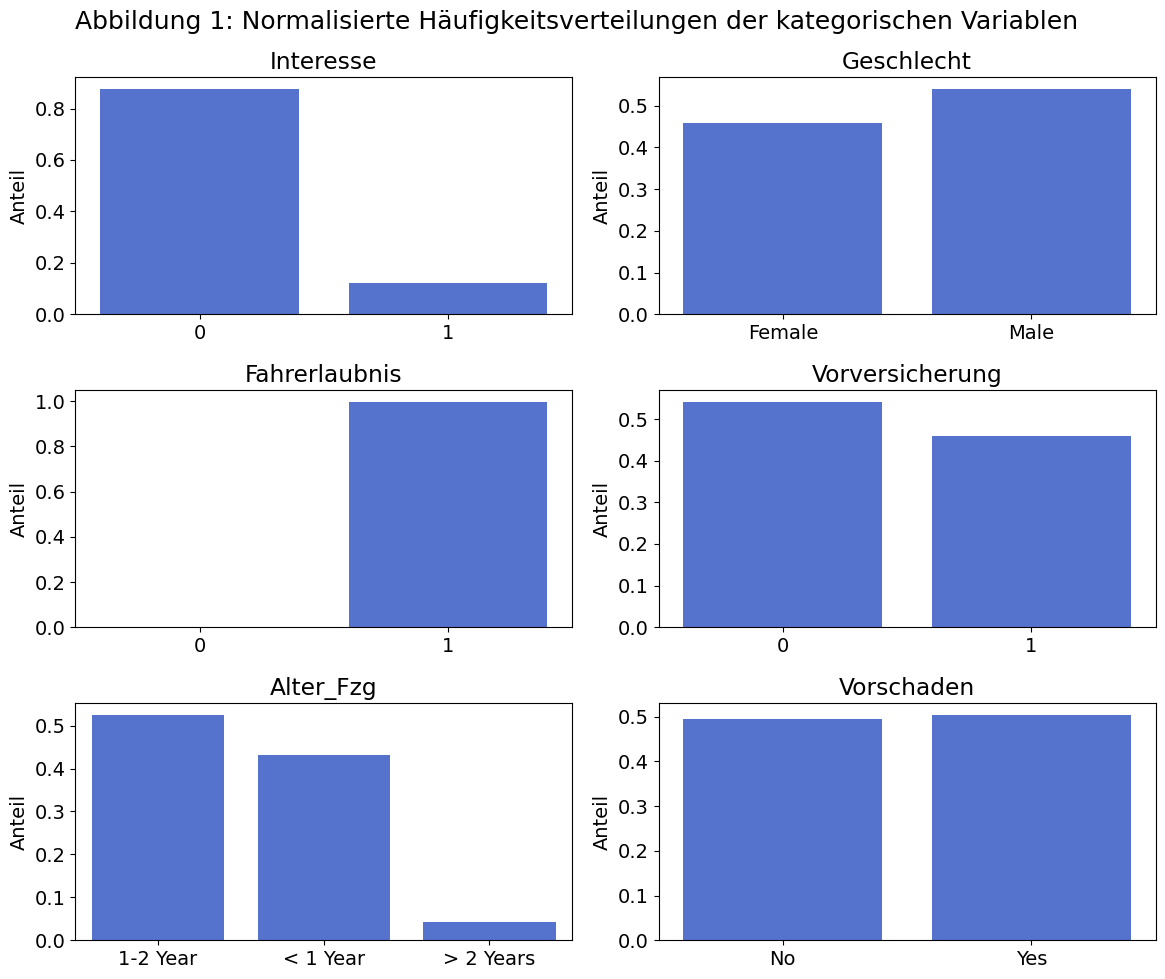

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

features = ['Interesse', 'Geschlecht', 'Fahrerlaubnis', 'Vorversicherung', 'Alter_Fzg', 'Vorschaden']

for ax, var in zip(axes.flatten(), features):
    # Compute normalized value counts
    value_counts = df[var].value_counts(normalize=True)
    
    # Create the barplot
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax, color="royalblue")

    # Format the plot
    ax.set_title(var)
    ax.set_xlabel(None)  # Adjust label based on dtype
    ax.set_ylabel("Anteil")
    
# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leaves space for the title
fig.suptitle("Abbildung 1: Normalisierte Häufigkeitsverteilungen der kategorischen Variablen", fontsize=18)
plt.show()


### 4.6.2) Numerische Merkmalen

Die folgende Abbildung zeigt die numerischen Merkmale in unseren Datensätzen. In der linken oberen Teilgrafik ist „Alter“ stark linksschief, was darauf hinweist, dass die Mehrheit der Personen in unserem Datensatz eher jünger ist. 

Wir sehen auch, dass „Jahresbeitrag“ extrem rechtsschief ist. Das Diagramm unten rechts untersucht die Beobachtungen im oberen Bereich (definiert als Personen, die mehr als 200.000 EUR/Jahr zahlen). Die relativ gleichmäßige Verteilung im oberen Bereich deutet darauf hin, dass es sich bei diesen statistischen Ausreißern wahrscheinlich nicht um Fehler bei der Dateneingabe handelt.

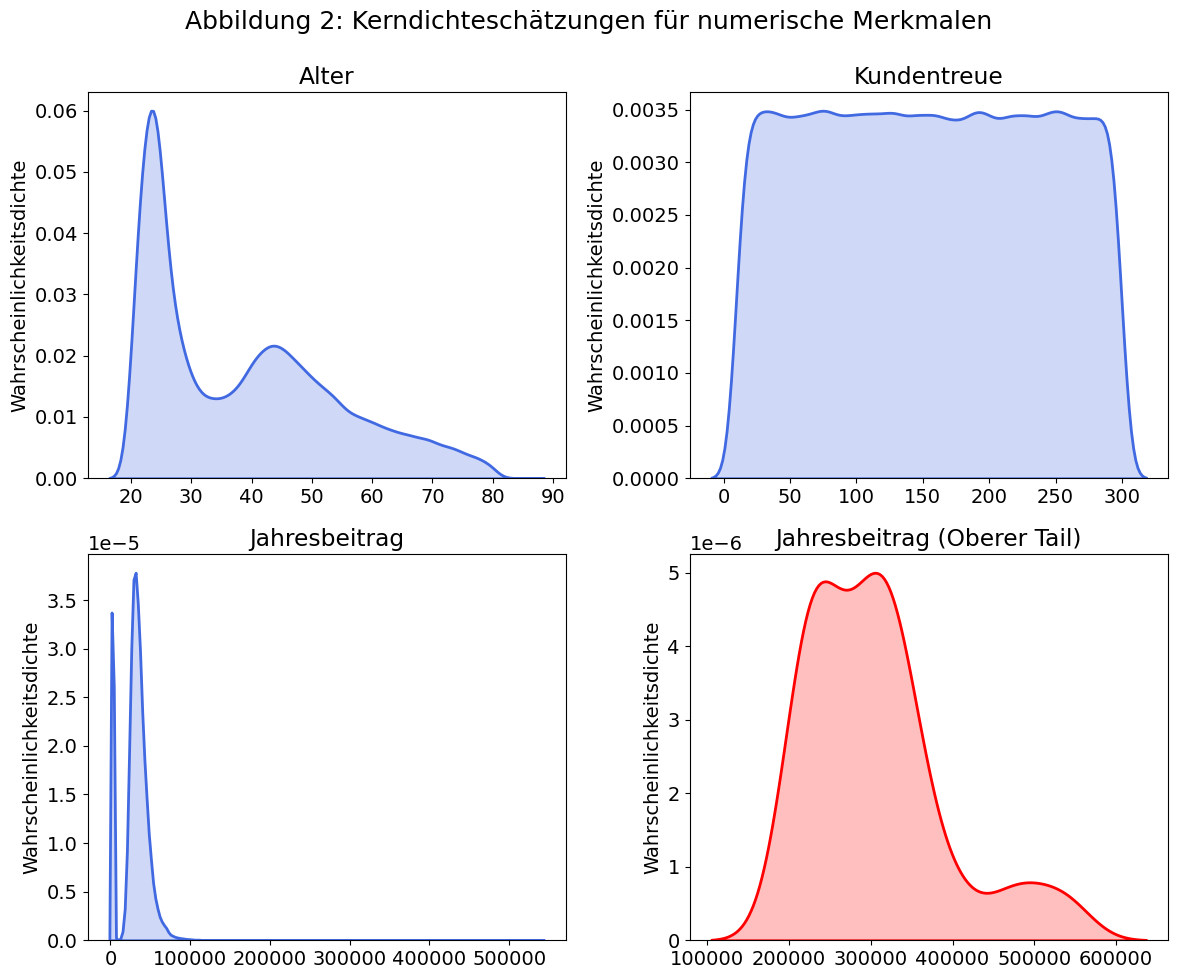

In [18]:
# Define figure and axes for 2x2 subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# **Add a global title for the entire figure**
fig.suptitle('Abbildung 2: Kerndichteschätzungen für numerische Merkmalen', fontsize=18)


# List of variables to plot
variables = ['Alter', 'Kundentreue', 'Jahresbeitrag']

# Iterate over the first three variables and create KDE plots
for i, var in enumerate(variables):
    row, col = divmod(i, 2)  # Convert index into row and column for subplot positioning
    sns.kdeplot(df[var], ax=axes[row, col], fill=True, color="royalblue", linewidth=2)
    axes[row, col].set_title(var)
    axes[row, col].set_xlabel(None)
    axes[row, col].set_ylabel("Wahrscheinlichkeitsdichte")

# **Fourth Plot: Analyze Upper Tail of Jahresbeitrag**
sns.kdeplot(df[df['Jahresbeitrag'] > 200_000]['Jahresbeitrag'], ax=axes[1, 1], fill=True, color="red", linewidth=2)
axes[1, 1].set_title("Jahresbeitrag (Oberer Tail)")
axes[1, 1].set_xlabel(None)
axes[1, 1].set_ylabel("Wahrscheinlichkeitsdichte")

# Adjust layout for better readability
plt.tight_layout(rect=[0, 0, 1, 0.99])

plt.show()

## 4.7) Bivariate Datenanalyse

### 4.7.1) Bivariate Assoziationen zwischen allen Merkmalen

Die folgende Heatmap zeigt die Beziehung zwischen jedem Merkmal in `df` und allen anderen Merkmalen. Die Messung dieser Beziehung hängt von der Art des Datentyppaares ab:

- Numerisch-Numerisch: [Pearson-Korrelation](https://de.wikipedia.org/wiki/Korrelationskoeffizient_nach_Bravais-Pearson), Wertebereich: -1 bis +1
- Numerisch-Kategorisch: [Correlation Ratio](https://en.wikipedia.org/wiki/Correlation_ratio), Wertebereich: 0 bis +1
- Kategorisch-Kategorisch: [Cramér's V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V), Wertebereich: 0 bis +1

Aufgrund der unterschiedlichen Wertebereiche der einzelnen Metriken wird zur besseren Vergleichbarkeit der ***absolute Wert*** verwendet.

In [19]:
corr = associations(df_, figsize=(15, 15), annot=False, multiprocessing=True, plot=False)

Interpretation: Die folgende Abbildung ist eine Heatmap, die die bivariate Beziehung zwischen den verschiedenen Spaltenkombinationen zeigt. Diese Beziehung wird als absoluter Wert dargestellt, so dass jeder Wert zwischen 0 und 1 liegt, wobei höhere Werte (dunklere Quadrate) eine stärkere bivariate Beziehung anzeigen.

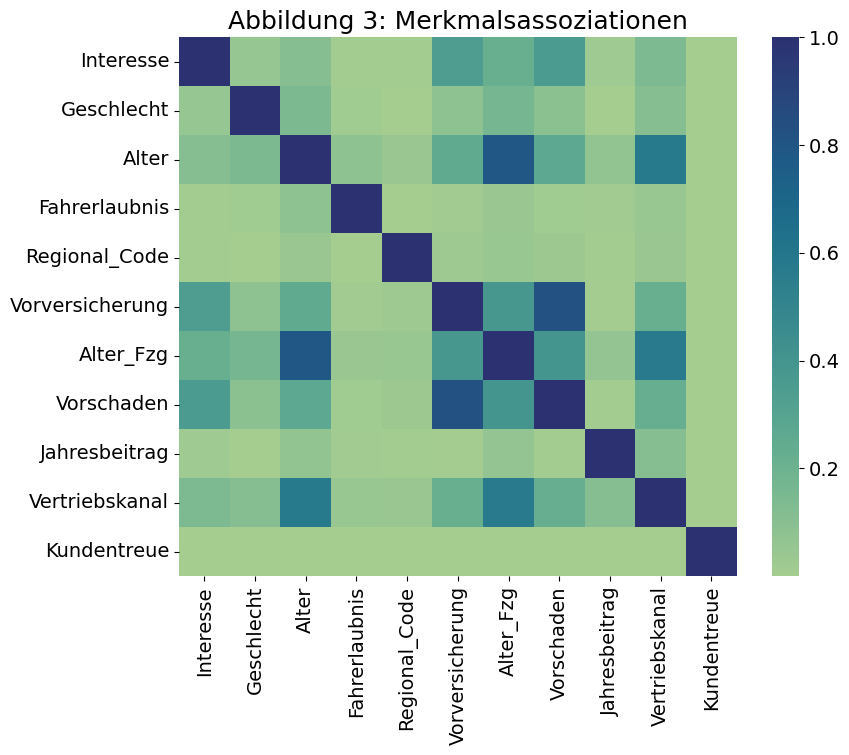

In [20]:
plt.figure(figsize=(9,7))
sns.heatmap(abs(corr['corr']), cmap='crest')
plt.title('Abbildung 3: Merkmalsassoziationen', fontsize=18)
plt.show()

### 4.7.2) Bivariate Merkmalsassoziationen mit der Zielvariable

Die folgende Abbildung 2 zeigt den bivariaten Zusammenhang zwischen den einzelnen Merkmalen und der Ergebnisvariablen „Interesse“ unter Verwendung der oben beschriebenen Maße.

Interpretation: Es zeigt sich, dass die Merkmale "Vorschaden", "Vorversicherung" und "Alter_Fzg" am stärksten mit der Zielgröße korrelieren.

In [21]:
corr_outcome = abs(corr['corr'].iloc[0, 1:]).sort_values(ascending=False)

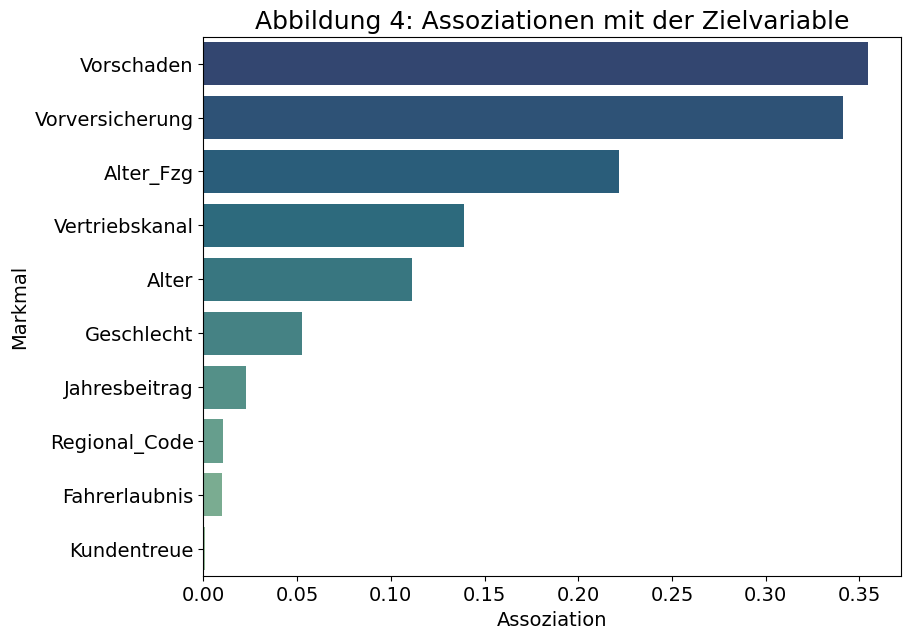

In [22]:
plt.figure(figsize=(9, 7))

num_categories = len(corr_outcome.index)
palette = sns.color_palette("crest", num_categories)[::-1]

sns.barplot(
    x=corr_outcome.values, 
    y=corr_outcome.index, 
    hue=corr_outcome.index,
    palette=palette, 
    legend=False
)
plt.xlabel("Assoziation")
plt.ylabel("Markmal")
plt.title('Abbildung 4: Assoziationen mit der Zielvariable', fontsize=18)
plt.show()

# 5.0) Vorverarbeitung für's ML Modell

## 5.1) Stratifizierte Aufteilung in Trainings-, Test- und Validierungsdaten

Da die Zielvariable, wie wir gesehen haben, klassenungleichgewichtig ist, müssen wir unsere Trainings-, Validierungs- und Testdatensätze stratifizieren, da sonst die Klassenverteilung in den Teilmengen ungleichmäßig sein kann. Im Folgenden wird erläutert, wie die einzelnen Daten-Teilsätze verwendet werden:

- `train` - allgemeines Modelltraining. Dieser Datensatz wird für die k-fache Kreuzvalidierung in 5 Falten unterteilt, um die richtige Anzahl von Boosting-Iterationen zu ermitteln
- `val` - kleine Teilmenge, die zum Schutz vor einer Überanpassung des endgültigen Modells verwendet wird
- `test` - bewertet die Leistung des endgültigen Modells

In [23]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0].astype(int)  # eforderlich für Stratifizierung und LGBM
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42, shuffle=True)

# Validierungsdatensatz um Overfitting zu verhindern
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.1, random_state=42, shuffle=True)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.mean(), y_val.mean(), y_test.mean())

(308480, 10) (34276, 10) (38084, 10)
0.1225849325726141 0.12259306803594351 0.12257115849175507


## 5.2) Umwandlung zum LGB-Datensatz-Typ

Für die Modellierung benutze ich LightGBM (siehe unten), was wiederum voraussetzt, dass die Datensätze in `lgb.Dataset` Objekten sind.

In [24]:
train = lgb.Dataset(data=X_train, label=y_train, categorical_feature='auto')
val = lgb.Dataset(data=X_val, label=y_val, categorical_feature='auto')
test = lgb.Dataset(data=X_test, label=y_test, categorical_feature='auto')

## 5.3) Eine Anmerkung zur Merkmalsnormalisierung (Feature Normalization)

[Merkmalsnormierung](https://en.wikipedia.org/wiki/Feature_scaling) (z. B. Min-Max-Normierung oder Z-Score-Normierung) ist eine gängige Praxis für viele ML-Modelle. Im Allgemeinen beschleunigt und stabilisiert sie das Modelltraining. Für baumbasierte Modelle, wie das von mir verwendete, ist diese Datentransformation jedoch *nicht notwendig*. Der Grund dafür ist, dass baumbasierte Modelle sich nicht um die absoluten Werte eines Merkmals kümmern, sondern nur um die Reihenfolge der Werte.

# 6.0) ML Modell - LightGBM

Für die Modellierung verwende ich [LightGBM](https://lightgbm.readthedocs.io/en/stable/index.html), ein Gradient Boosting Framework, das baumbasierte Lernalgorithmen für Raking, Klassifikation und Regression verwendet. [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) ist eine Form des maschinellen Lernens, bei der das Ziel iterativ an die Pseudoresiduen der vorhergehenden Modelle angepasst wird. Dieses Framework eignet sich daher für eine Reihe schwacher Modelle (z. B. Decision Trees), die zu einem einzigen starken Lerner kombiniert werden.

LightGBM unterscheidet sich von anderen Gradient Boosting Decision Tree Frameworks (z.B. XGBoost) dadurch, dass die Bäume blattweise und nicht stufenweise wachsen. Um das Training zu beschleunigen und den Speicherbedarf zu reduzieren, verwendet LGBM außerdem histogrammbasierte Algorithmen, um kontinuierliche Merkmalswerte in diskrete Bins zu unterteilen.

## 6.1) Modellvergleich

Warum ein Gradienten-Boosting-Modell für die Aufgabe? 

Gradient Boosted Modelle eignen sich hervorragend für Klassifikation, Regression und Ranking bei großen Datenmengen. Im Vergleich zu Bagged (Random Forest) Methoden haben Boosted Modelle in der Regel eine geringere Verzerrung und sind bei kleinen Datensätzen schneller, neigen aber zur Überanpassung, die durch Regularisierung korrigiert werden kann.

Im Vergleich zu Support-Vector-Machines (SVM - einschließlich SVC) sind Boosted-Modelle bei großen Datensätzen effizienter, reagieren weniger empfindlich auf die Skalierung von Merkmalen und erfordern weniger Feature-Engineering (z. B. Behandlung fehlender Werte, One-Hot-Codierung). SVMs berechnen auch nicht inhärent Vorhersagewahrscheinlichkeiten (die in unserem Fall wichtig sind, wie weiter unten erläutert wird). Vorhersagewahrscheinlichkeiten können geschätzt werden, aber dies ist bei großen Datenmengen sehr rechenintensiv und kann auch zu [inkonsistenten Ergebnissen](https://scikit-learn.org/stable/modules/svm.html#scores-probabilities) führen.

Bei tabellarischen Daten, wie sie hier vorliegen, sind geboostete Modelle in der Regel Deep-Learning-Modellen überlegen, ohne dass große Trainingsdatensätze oder teure Berechnungen (häufig unter Verwendung einer GPU) erforderlich sind. Während Deep-Learning-Modelle bei nicht-tabellarischen Daten und tabellarischen Zeitreihen besser abschneiden als Boosted-Modelle, sind Boosted-Modelle vorzuziehen, da diese Daten einen einfachen tabellarischen Querschnitt darstellen.

In einer realen Anwendung würde man die Leistung mit einer Vielzahl von Modellen vergleichen und möglicherweise sogar die Vorhersagen verschiedener Modelltypen durch [Model Stacking](https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html) kombiniere

## 6.2) Modellanwendung

Gradient-boosted Modelle sind sehr anfällig für eine Überanpassung ([Overfitting](https://en.wikipedia.org/wiki/Overfitting)) an die Trainingsmenge. Ein zentraler Mechanismus, um dies zu kontrollieren, ist die Anzahl der Boosting-Iterationen. Ohne umfangreiche Modell-Hyperoptimierung (z. B. Optuna) können wir die optimale Anzahl von Boosting-Iterationen durch „Early Stopping“ mit einem oder mehreren Validierungssätzen wählen. Obwohl rechenintensiver, ist die Verwendung von mehr als einem Validierungsset (z.B. [k-fold Validierung](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)) vorzuziehen, da dies die Robustheit des Stoppkriteriums und damit die optimale Anzahl von Boosting-Iterationen erhöht. Im Folgenden wird eine 5-fold geschichtete Validierungsmethode verwendet, bei der wiederum nach dem unbalancierten Ergebnismerkmal geschichtet wird.

In [25]:
# Model Parameters
params = {
    "objective": "binary",
    "metric": ['average_precision', "binary_logloss"],  # uses average_precision for early stopping
    "verbose": -1,
    "boosting_type": "gbdt",  # default
    "num_threads": 8,
    "seed": 42,
    "num_iterations": 200,  # aka n_estimators, ensure early stopping engaged
    "device_type": "cpu",
    "num_leaves": 31,  # default
    "max_depth": -1,  # default
    "min_data_in_leaf": 20,  # default
    "tree_learner": "serial",  # default
    "bagging_fraction": 1.0,  # default
    "bagging_freq": 0,  # default
    "feature_fraction": 1.0,  # default
    "learning_rate": 0.1,  # default
    "early_stopping_round": 10,
    "drop_rate": 0.1,  # default
    "lambda_l1": 0.0,  # default
    "lambda_l2": 0.0,  # default
}

In [26]:
current = time()

cv_results = lgb.cv(params, 
                    train, 
                    nfold=5, 
                    stratified=True, 
                    shuffle=True, 
                    metrics='average_precision')

print(f"\nGesamtzeit: {round(time() - current, 2)} Sekunden. \n")


Gesamtzeit: 0.93 Sekunden. 



In [27]:
best_num_boost_rounds = len(cv_results['valid average_precision-mean'])
print(f"Optimale Iteration basierend auf K-Fold-Cross-Validation: {best_num_boost_rounds}")

Optimale Iteration basierend auf K-Fold-Cross-Validation: 40


## 6.3) Modelltraining

Hier geht es um das Haupttraining des Modells. Dabei verwende ich einen kleinen Validierungsdatensatz, um eine Überanpassung des endgültigen Modells zu vermeiden und die Modellleistung zu messen.

In [28]:
params_best = params.copy()
params_best['num_iterations'] = best_num_boost_rounds
params_best['early_stopping_round'] = 5

current = time()

eval_results = {}
record_cb = lgb.record_evaluation(eval_results)

bst = lgb.train(params=params_best, 
                train_set=train,
                valid_sets=[train, val],
                valid_names=['train', 'val'],
                callbacks=[record_cb])

print(f"Gesamtzeit: {round(time() - current, 2)} Sekunden. \n")

Gesamtzeit: 0.19 Sekunden. 



## 6.4) Abbildungen zum Modelltraining

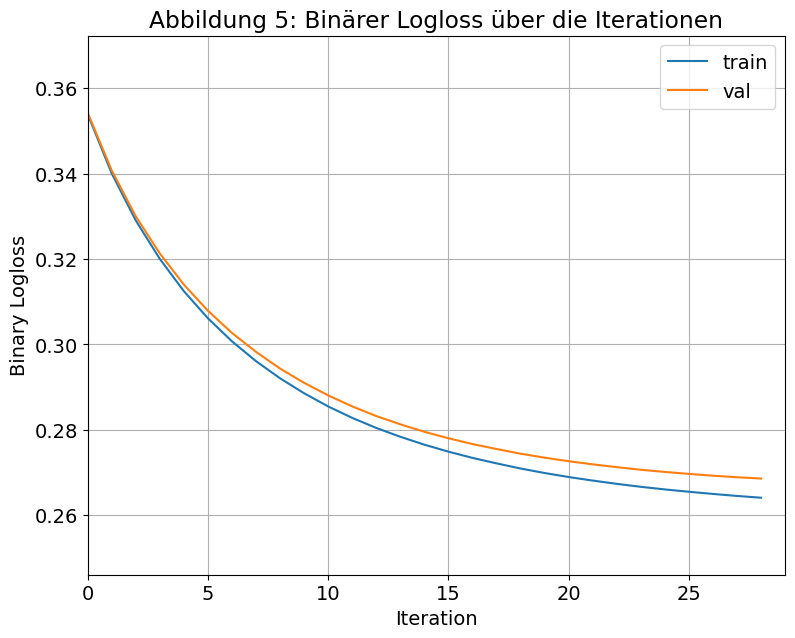

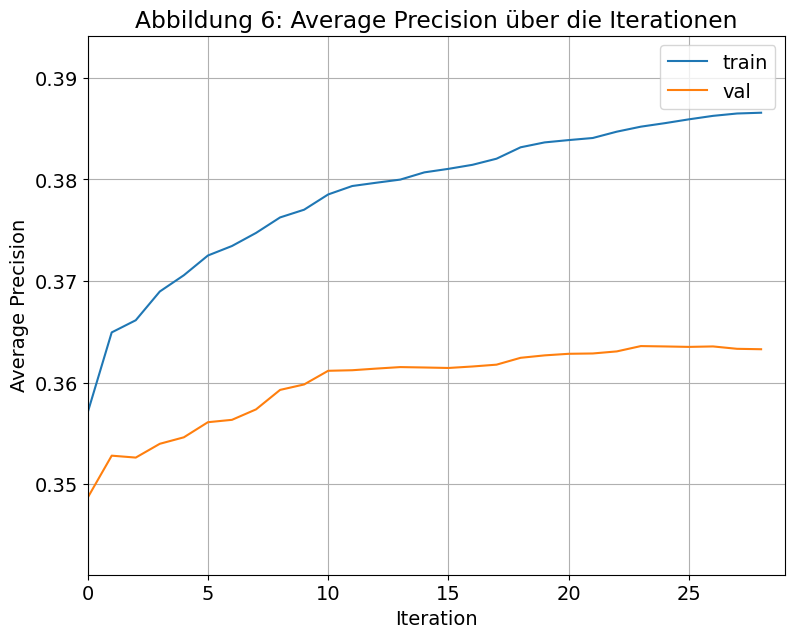

In [29]:
lgb.plot_metric(eval_results, metric='binary_logloss', ylabel='Binary Logloss', xlabel='Iteration',
                figsize=(9, 7), title='Abbildung 5: Binärer Logloss über die Iterationen')

lgb.plot_metric(eval_results, metric='average_precision', ylabel='Average Precision', xlabel='Iteration',
                figsize=(9, 7), title='Abbildung 6: Average Precision über die Iterationen')
plt.show()

## 6.5) Verteilung der Vorhersagewahrscheinlichkeiten im Testdatensatz

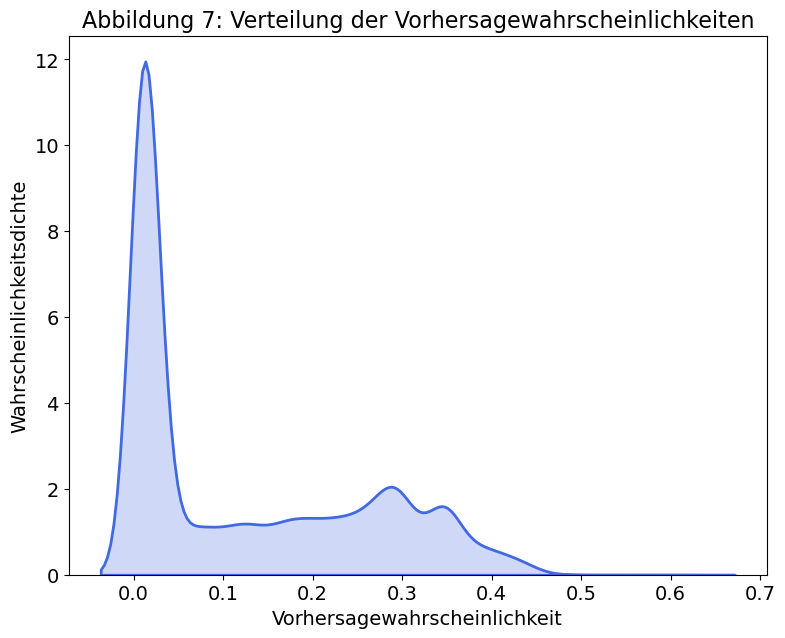

In [30]:
y_pred_proba = bst.predict(X_test)

plt.figure(figsize=(9, 7))
sns.kdeplot(y_pred_proba, fill=True, color="royalblue", linewidth=2)
plt.title(f"Abbildung 7: Verteilung der Vorhersagewahrscheinlichkeiten", fontsize=16)
plt.ylabel("Wahrscheinlichkeitsdichte")
plt.xlabel("Vorhersagewahrscheinlichkeit")
plt.show()


# 7.0) Modellleistung

## 7.1) Precision-Recall Curve

Aufgrund des Klassenungleichgewichts im Zielmerkmal verwende ich Precision, Recall und Average Precision als Leistungsmetriken. Standardmetriken wie die Genauigkeit (Accuracy) oder die Area unter der Receiver Operating Characteristic Curve (ROC AUC) sind bei Klassenungleichgewicht nicht geeignet.

Die Precision ist ein Maß für den Anteil der relevanten Beobachtungen an den tatsächlich zurückgegebenen Beobachtungen, während die Recall ein Maß für den Anteil der zurückgegebenen Beobachtungen an allen Beobachtungen ist, die hätten zurückgegeben werden sollen. Bei Klassifizierungsaufgaben werden Precision und Recall durch eine Entscheidungsgrenze bestimmt. Dementsprechend zeigt die Precision-Recall-Kurve (PR-Kurve) den Kompromiss zwischen Precision und Recall für verschiedene Klassifizierungsschwellen. Eine große Area unter der PR-Kurve steht für eine hohe Precision und einen hohen Recall, was wünschenswert ist. Die Average Precision (AP) ist ein zusammenfassendes Maß für die Precision-Recall-Curve, das den gewichteten Durchschnitt der Precision für jeden Schwellenwert angibt.

Je nach Fall kann die Precision wichtiger als die Recall sein oder umgekehrt. Ohne weitere Informationen nehme ich in diesem Fall an, dass beide gleichermaßen wünschenswert sind.

In [31]:
# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Compute Average Precision (AP)
ap_score = average_precision_score(y_test, y_pred_proba)

# Compute minority class proportion in test set
minority_class_proportion = np.mean(y_test)  # Since minority class = 1

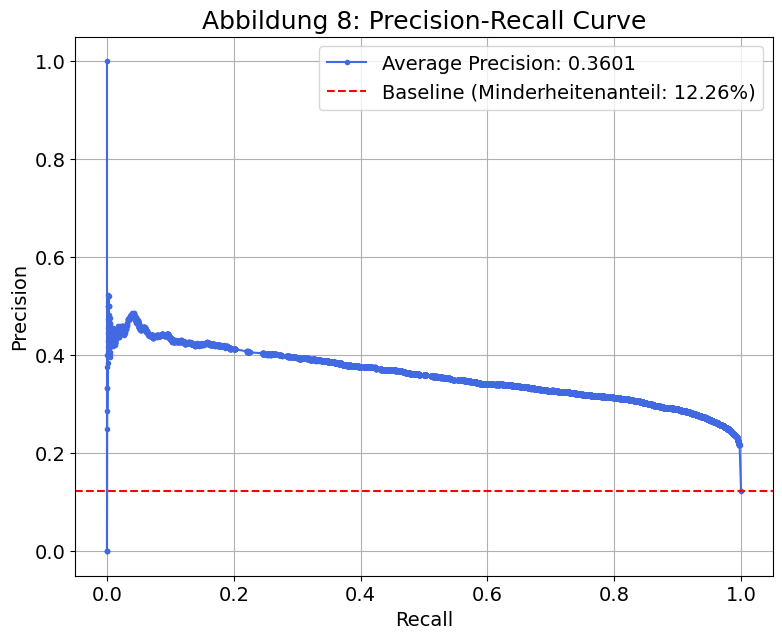

In [32]:
# Plot the Precision-Recall Curve
plt.figure(figsize=(9, 7))
plt.plot(recall, precision, marker='.', label=f'Average Precision: {ap_score:.4f}', color='royalblue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Abbildung 8: Precision-Recall Curve', fontsize=18)
plt.axhline(y=minority_class_proportion, color='red', linestyle='dashed', label=f'Baseline (Minderheitenanteil: {minority_class_proportion:.2%})')
plt.legend()
plt.grid(True)
plt.show()

## 7.2) Beste Klassifikationsschwelle aus der Precision-Recall-Kurve

Mit Hilfe der Precision-Recall-Kurven können wir den optimalen Klassifikationsschwelle für die Einstufung der Wahrscheinlichkeiten in eine der beiden Klassen bestimmen. Hier verwenden wir für jeden Schwellenwert den f1-Score, der das harmonische Mittel (harmonic mean) aus Precision und Recall berechnet, unter der Annahme, dass beide gleich wichtig sind. Der optimale Schwellenwert ergibt sich aus dem argmax der f1-Scores.

Abbildung 9 zeigt den Zusammenhang zwischen dem Entscheidungsgrenzwert und dem F1-Score, wobei der Scheitelpunkt der Kurve den optimalen Entscheidungsgrenzwert darstellt.

In [33]:
# Compute F1-score for each threshold - takes a couple seconds
current = time()
f1_scores = [f1_score(y_test, y_pred_proba >= t) for t in thresholds]
print(f"\nGesamtzeit: {round(time() - current, 2)} Sekunden. \n")

best_threshold = thresholds[np.argmax(f1_scores)] 

best_f1 = max(f1_scores)


Gesamtzeit: 18.7 Sekunden. 



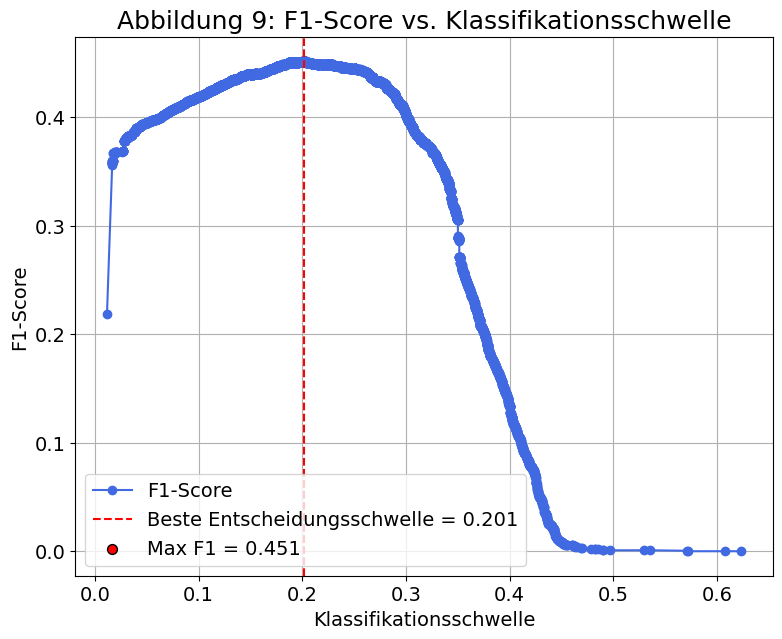

In [34]:
# Plot F1-score vs. Threshold
plt.figure(figsize=(9, 7))
plt.plot(thresholds, f1_scores, marker='o', linestyle='-', color='royalblue', label="F1-Score")
plt.axvline(x=best_threshold, color='red', linestyle='dashed', label=f'Beste Entscheidungsschwelle = {best_threshold:.3f}')
plt.scatter(best_threshold, best_f1, color='red', s=50, edgecolors='black', label=f'Max F1 = {best_f1:.3f}')
plt.xlabel('Klassifikationsschwelle')
plt.ylabel('F1-Score')
plt.title('Abbildung 9: F1-Score vs. Klassifikationsschwelle', fontsize=18)
plt.legend()
plt.grid(True)
plt.show()